# Creating Applications with Langchain

## Case Study: Resumes

Suppose we want to extract some meaningful information out of a bunch of resumes. While resumes contain a lot of the same information (e.g., education, experience, skills), they can all be formatted very differently. Therefore, extracting structured data from these files can be very challenging with standard document parsing code. What we can do instead is use a LLM to decipher this information for us.

We'll use a publicly-available [set](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset?resource=download) of 2400+ annonymized PDF resumes labeled with the category of the job for which the person applied.

Before we begin, we will need to install the following packages:

```python
pip install openai langchain chromadb tiktoken pypdf lark>=1.1.5
```

In [1]:
import os
RESUME_ROOT_DIR = os.path.expanduser('~/Documents/resume_data/data/data/')
PERSIST_DIR = os.path.expanduser("~/Documents/resume_data/persist/")

import os
path_to_file = os.path.expanduser('~/openai-key.txt')
with open(path_to_file, 'r') as f:
    os.environ['OPENAI_API_KEY'] = f.read().strip()

FileNotFoundError: [Errno 2] No such file or directory: '/home/wkt406/openai-key.txt'

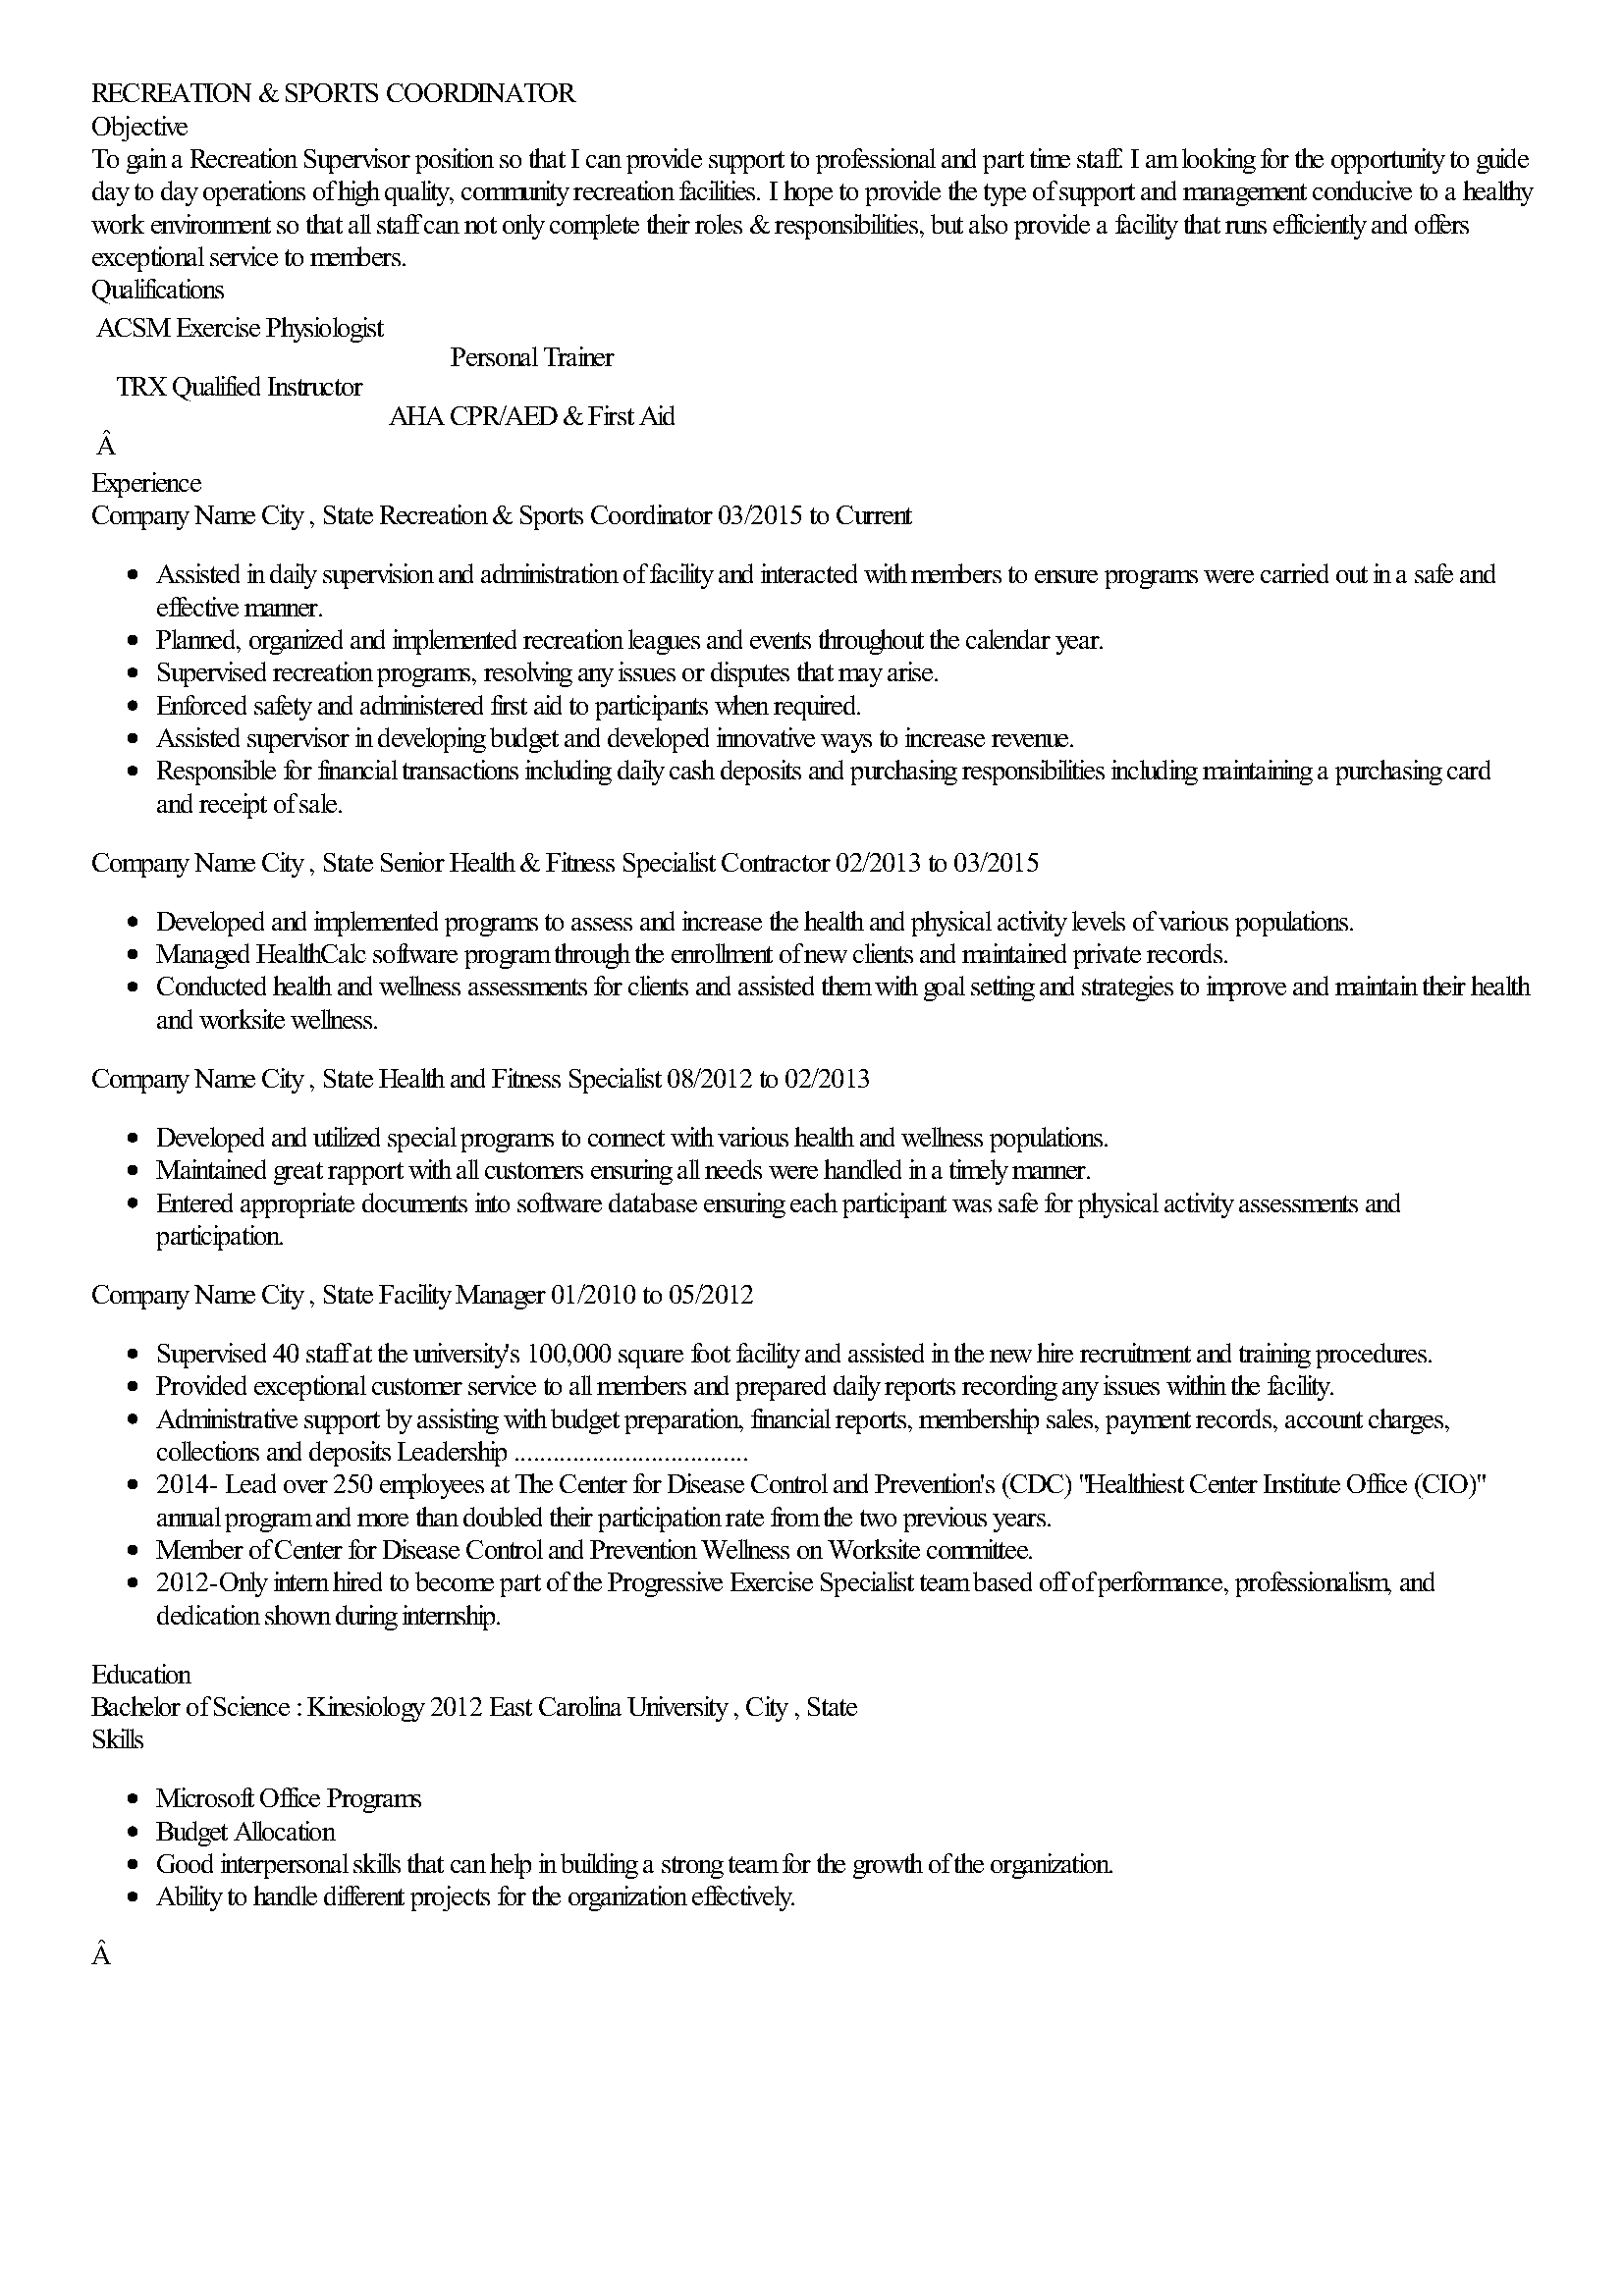

In [2]:
### display the image in the notebook

from IPython.display import Image
fig = Image(filename='images/resume.png')
fig

We can load in the text from a PDF document using one of several PDF loaders available from Python libraries (pypdf,pymupdf,pdfplumer,pdfminer). Langchain acts as a wrapper to unite all of the different APIs.

In [3]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader(os.path.join(RESUME_ROOT_DIR,'FITNESS','10428916.pdf'))
pages = loader.load_and_split()

print(pages[0].page_content[:550])

RECREATION & SPORTS COORDINATOR
Objective
To gain a Recreation Supervisor position so that I can provide support to professional and part time staff. I am looking for the opportunity to guide
day to day operations of high quality, community recreation facilities. I hope to provide the type of support and management conducive to a healthy
work environment so that all staff can not only complete their roles & responsibilities, but also provide a facility that runs efficiently and offers
exceptional service to members.
Qualifications
ACSM Exercise


We could potentially submit a prompt containing all the text from the PDF as context and then ask the AI a question. However, a lot of times, the PDF will contain much more text than the maximum number of prompt context tokens (i.e., too long for a single call to the API). This problem becomes even more severe if we want to extract information from all of the PDFs in this dataset. Therefore, we need to come up with another solution.

### Vector stores

We can instead take our unstructured text data, embed the tokens into an embedding vector, and then store all of those vectors in a database. When it comes time to query the data, we then embed the query in the same way and find embedding vectors in the database that are 'most similar' to the query.

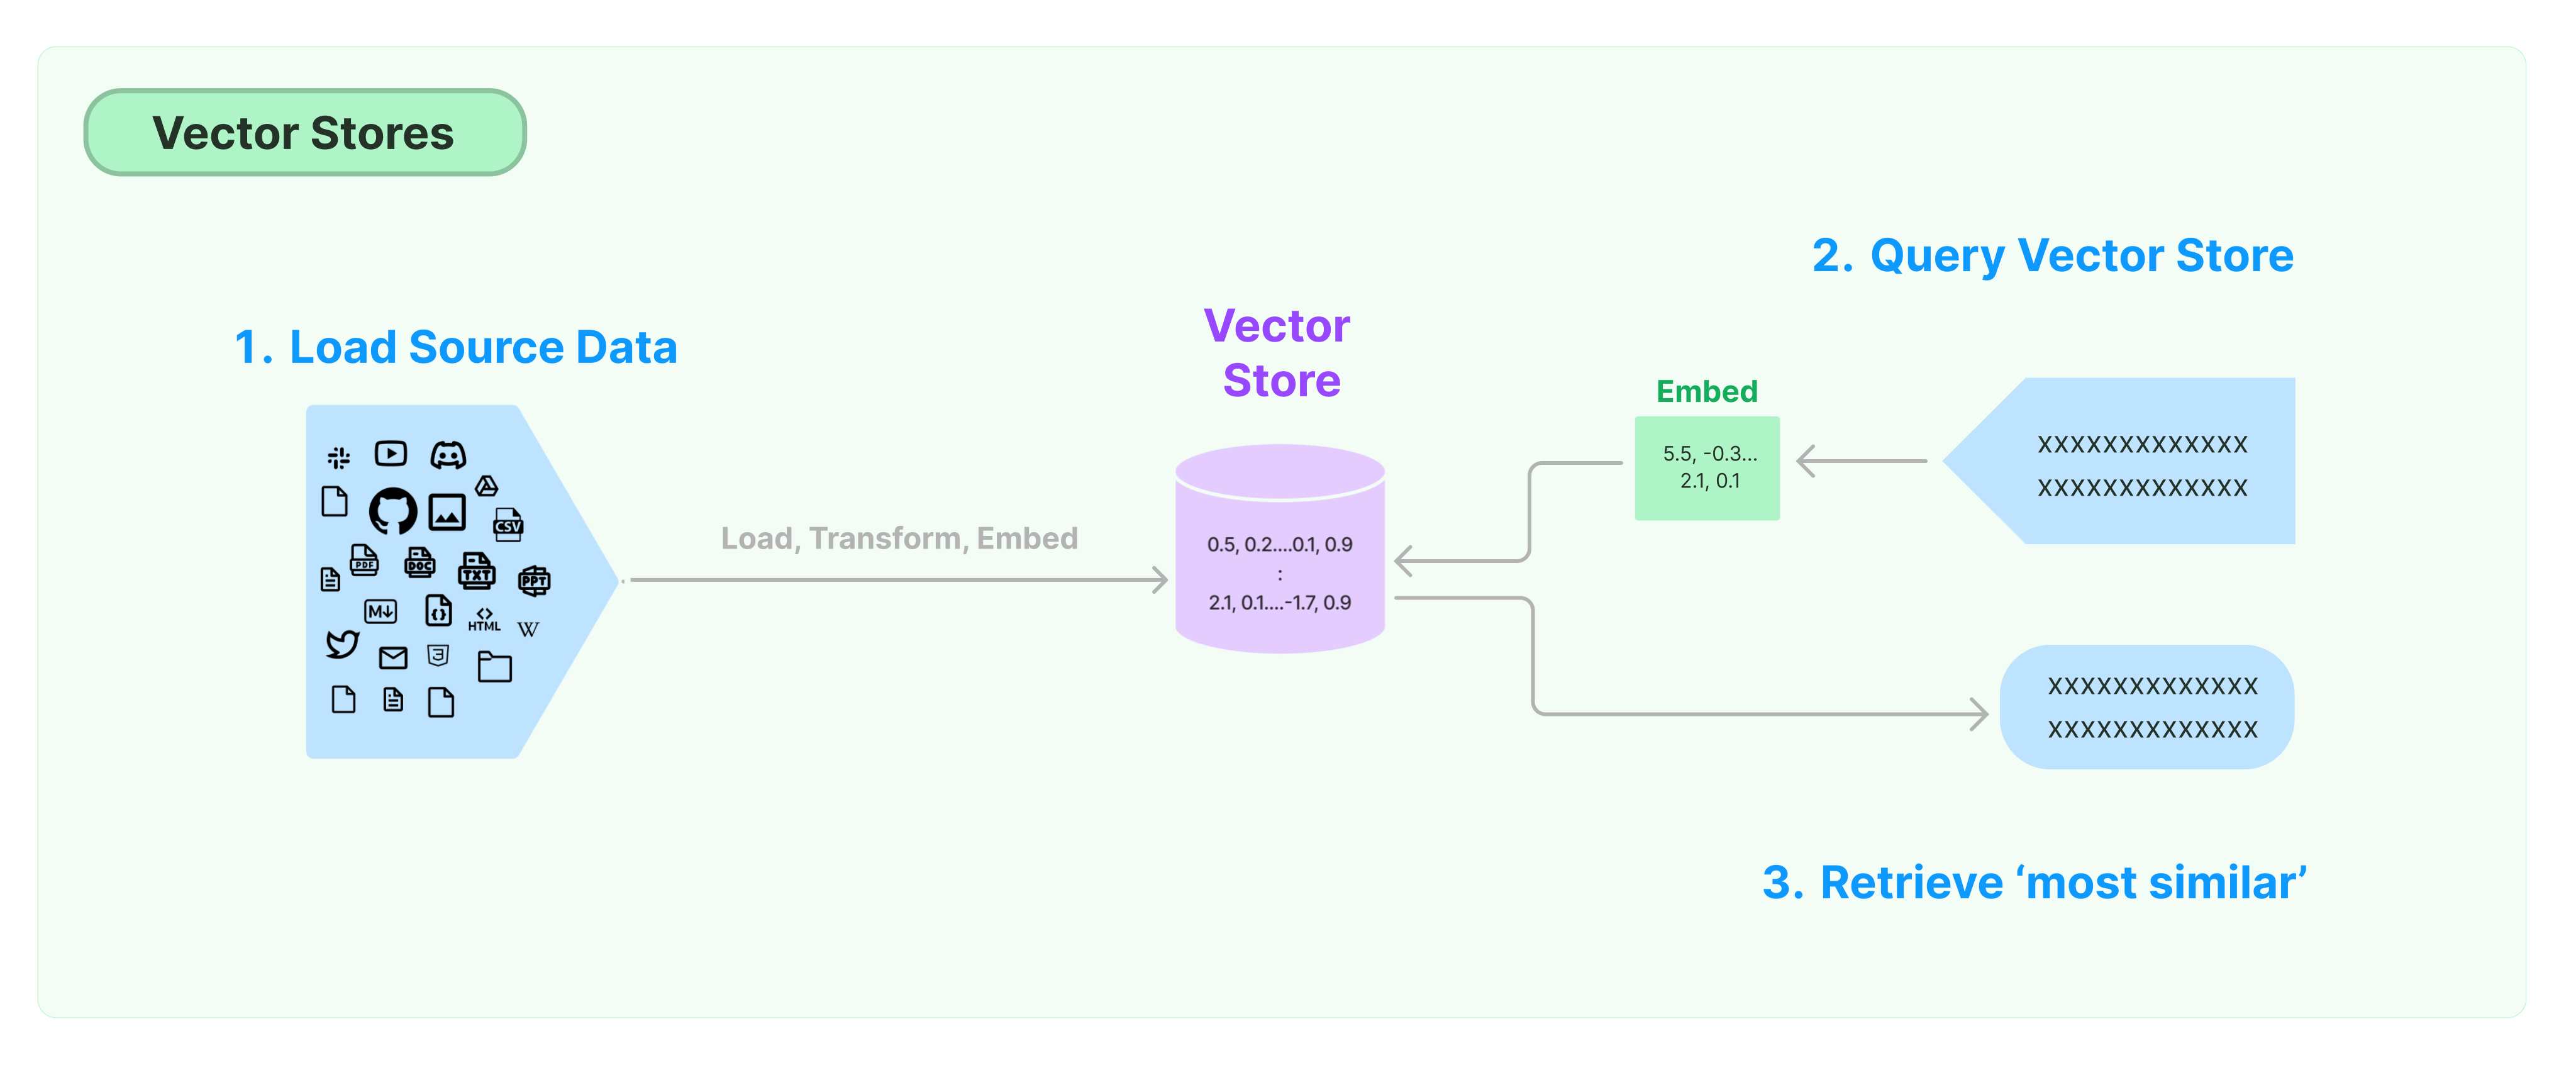

In [4]:
## display image of vector stores

from IPython.display import Image
fig = Image(filename='images/vector_stores.jpeg')
fig

### Conducting a similarity search on a single document

Let's take the document we loaded earlier and query it using a vector database. Since we are searching for a specific part of the text that matches our query, we'll want to break up the PDF into smaller chunks. A simple way to to this is to break up the text into discrete chunks, separated by the characther "\n". We'll see why in a later example why that might not be ideal in all cases, but for now, we'll go with it. There is also a parameter that allows for some overlap between the chunks so that any relevant part of our search doesn't get cut into two pieces.

The first element of docs is the vector with the highest similarity score. When we print out the context, we see that it does in fact contain the text that shows the person's education.

In [5]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size=200,chunk_overlap=10,separator='\n')
chunks = text_splitter.split_documents(pages)
db = Chroma.from_documents(chunks,OpenAIEmbeddings())

query = "What is the highest level of education listed in this resume?"
docs = db.similarity_search(query)

print(docs[0].page_content)

ACSM Exercise Physiologist
TRX Qualified Instructor
Â 
Personal Trainer
AHA CPR/AED & First Aid
Experience
Company Name
 
City
 
, 
State
 
Recreation & Sports Coordinator
 
03/2015
 
to 
Current


It's important to note that we didn't actually submit any query to OpenAI. We only used their embeddings to create our vector database. In this case, Chroma (the third-party module we used in this example) computed the similarity score mathematically and only returned the text. This can be a useful way of searching a lot of documents for information without needing to send a bunch of API calls to an AI.

Of course, we can get a more sophisticated and structured response if we instead point an AI toward our vector database as context for answering our query.

### Creating a persistent vector database

If we want to conduct searches on multiple documents, it will be beneficial for us to instead place the documents into a persistent storage database rather than one in memory. That way, we only have to embed each document a single time and save the database to disk.

We'll use the directory loader to import and embed several PDFs from the same root directory.

In [6]:
from langchain.document_loaders import DirectoryLoader

def fetch_and_load_documents(category,verbose=True):
    loader = DirectoryLoader(os.path.join(RESUME_ROOT_DIR,category),
                             glob='*.pdf',
                             loader_cls=PyPDFLoader,
                             show_progress=verbose)
    resumes = loader.load()
    return resumes

Just as before, we'll have to split the documents up into smaller chunks. The model we are using for OpenAI is limited to a context window of ~4k tokens. To be safe, let's split the text up into chunks that are slightly smaller than that. This time, we'll use a slightly more sophisticated text splitter: recursive character text splitter. We'll set a maximum length for the text we want to embed as a vector and start by splitting the document up by sections (e.g., string split on "\n\n"). If any of those chunks are too big, we'll go to that chunk and split it up by paragraphs (e.g., string split on "\n"). We'll continue this strategy down to individual words and then characters (e.g., string split on " " and "", respectively.) While all the resumes are formatted differently, we do know that they tend to be split up into sections in this manner, with each section being a semantically meaningful chunk of information.

Again, we'll include some overlap between the chunks to help tie them together. As we are using an AI this time, we'll want to actually define the unit of the "chunk" to be tokens, as defined by the tokenization function used in model we've selected. We'll be using OpenAI's gpt-3.5-turbo. The first bit of the code below is a helper function that we can use to define the length of any text in tokens using the tiktoken module.

In [7]:
import tiktoken
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    num_tokens = len(encoding.encode(string))
    return num_tokens

## split the text up into smaller chunks that the API can handle
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2048,
    chunk_overlap=256,
    length_function=num_tokens_from_string,
    separators=['\n\n', '\n', ' ', '']
)

Next, we'll want to write a function that creates a "document" out of every chunk of text from each PDF. In addition to the text itself, we can add metadata about the document itself. In this example, the only other information we have about each document is the job category for which the resume was submitted. If we had other identifying information, such as candidate name, gender, race, ethnicity, applying company, date submitted, etc., we could add those lines into the metadata dictionary as well.

We will also need to create a unique identifier for each document. Each resume PDF has a unique file name, so let's start by using that as the ID. Next, whenever we load in a PDF, it is automatically split up by pages, so the page number will become the second part of the ID. Finally, we need to index each individual chunk of text uniquely, so we'll create a third piece to the ID which is the chunk number on the page.

In [8]:
from langchain.schema import Document
def create_chroma_document(resume,category=None):
    ## the source is the filename of the document
    ## extract the file name w/o extension as the first part of the ID
    file_num = resume.metadata['source'].split('/')[-1].split('.')[0]
    page = resume.metadata['page']
    resume.metadata['job_category'] = category.lower().replace('-',' ')
    chunks = text_splitter.split_text(resume.page_content)
    
    documents = []
    ids = []
    for i, chunk in enumerate(chunks):
        documents.append(
            Document(page_content=chunk,
                     metadata=resume.metadata)
            )
        ids.append(f'{file_num}-{page}-{i}')

    return documents, ids

In [9]:
## creates a vector database from all of the resumes in the data directory
def create_vector_database():
    all_documents = []
    all_ids = []
    categories = list(os.listdir(RESUME_ROOT_DIR))    
    for i,category in enumerate(categories):
        print(f'Processing {category}...{i+1}/{len(categories)}')
        resumes = fetch_and_load_documents(category)
        
        for resume in resumes:
            documents, ids = create_chroma_document(resume,category)
            all_documents.extend(documents)
            all_ids.extend(ids)
            
    print('Creating vector database...',end='')
    vector_db = Chroma.from_documents(all_documents,
                                      ids=all_ids,
                                      embedding=OpenAIEmbeddings(),
                                      persist_directory=PERSIST_DIR)

    vector_db.persist()
    print('Done.')
    
    return vector_db
            
## here's a helper function that will load the vector database from disk if it exists
## or will create it if it doesn't or if we want to refresh it
def load_vector_database(refresh=False):
    if os.path.exists(PERSIST_DIR) and not refresh:
        print('Loading vector database from disk...',end='')
        vector_db = Chroma.load_from_disk(PERSIST_DIR)
        print('Done.')
    else:
        vector_db = create_vector_database()
        
    return vector_db

In [10]:
vector_db = create_vector_database()

Processing AGRICULTURE...1/24


  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:05<00:00, 11.71it/s]


Processing ARTS...2/24


100%|██████████| 103/103 [00:08<00:00, 12.80it/s]


Processing SALES...3/24


100%|██████████| 116/116 [00:07<00:00, 14.60it/s]


Processing CONSULTANT...4/24


100%|██████████| 115/115 [00:10<00:00, 11.43it/s]


Processing DIGITAL-MEDIA...5/24


100%|██████████| 96/96 [00:07<00:00, 12.71it/s]


Processing CHEF...6/24


100%|██████████| 118/118 [00:08<00:00, 13.42it/s]


Processing HEALTHCARE...7/24


100%|██████████| 115/115 [00:10<00:00, 11.11it/s]


Processing PUBLIC-RELATIONS...8/24


100%|██████████| 111/111 [00:09<00:00, 11.27it/s]


Processing AVIATION...9/24


100%|██████████| 117/117 [00:09<00:00, 12.51it/s]


Processing BANKING...10/24


100%|██████████| 115/115 [00:09<00:00, 12.47it/s]


Processing ACCOUNTANT...11/24


100%|██████████| 118/118 [00:09<00:00, 12.17it/s]


Processing INFORMATION-TECHNOLOGY...12/24


100%|██████████| 120/120 [00:11<00:00, 10.68it/s]


Processing HR...13/24


100%|██████████| 110/110 [00:09<00:00, 11.34it/s]


Processing CONSTRUCTION...14/24


100%|██████████| 112/112 [00:09<00:00, 11.54it/s]


Processing DESIGNER...15/24


100%|██████████| 107/107 [00:08<00:00, 13.28it/s]


Processing FINANCE...16/24


100%|██████████| 118/118 [00:09<00:00, 12.12it/s]


Processing FITNESS...17/24


100%|██████████| 117/117 [00:08<00:00, 13.47it/s]


Processing BUSINESS-DEVELOPMENT...18/24


100%|██████████| 120/120 [00:09<00:00, 12.49it/s]


Processing APPAREL...19/24


100%|██████████| 97/97 [00:07<00:00, 12.38it/s]


Processing ADVOCATE...20/24


100%|██████████| 118/118 [00:10<00:00, 11.42it/s]


Processing BPO...21/24


100%|██████████| 22/22 [00:02<00:00, 10.43it/s]


Processing TEACHER...22/24


100%|██████████| 102/102 [00:07<00:00, 13.42it/s]


Processing ENGINEERING...23/24


100%|██████████| 118/118 [00:10<00:00, 11.70it/s]


Processing AUTOMOBILE...24/24


100%|██████████| 36/36 [00:03<00:00, 11.93it/s]


Creating vector database...

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for text-embedding-ada-002 in organization org-EqQCXPlo5dygueWmKaAZPpPN on tokens per min. Limit: 1000000 / min. Current: 490247 / min. Visit https://platform.openai.com/account/rate-limits to learn more..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for text-embedding-ada-002 in organization org-EqQCXPlo5dygueWmKaAZPpPN on tokens per min. Limit: 1000000 / min. Current: 408775 / min. Visit https://platform.openai.com/account/rate-limits to learn more..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for text-embedding-ada-002 in organization org-EqQCXPlo5dygueWmKaAZPpPN on tokens per min. Limit: 1000000 / min. Current: 790740 / min. Visit https://platfo

Done.


### Retrieve documents from the vector database using an LLM

We've been able so far just use a similarity search between the query and document contents. But what if we wanted to do something more complicated, such as searching over all of our documents with an unstructured query. We would need a LLM to interpret the query and translate it into a more structured query language (i.e., SQL-like) so that it can not only compute a similarity score but also filter based on any metadata criteria. We can do this using the self query retriever. We can give context to the LLM by providing descriptions of the data set (i.e., the documents are resumes) and the metadata fields (i.e., we pre-labeled each resume with a job category).

In [11]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever

def get_retriever(vectorstore):
    metadata_field_info = [
        AttributeInfo(
            name='job_category',
            type='string',
            is_categorical=True,
            is_searchable=True,
            description='The category of the job for which the resume was submitted.'
        ),
        AttributeInfo(
            name='source',
            type='string',
            is_categorical=False,
            is_searchable=False,
            description='The PDF file name of the resume.'
        ),  
    ]

    retriever = SelfQueryRetriever.from_llm(
        llm=ChatOpenAI(temperature=0,model_name='gpt-3.5-turbo'),
        vectorstore=vectorstore,
        document_contents='Annonymized resumes for job applications in various categories.',
        metadata_field_info=metadata_field_info
    )
    
    return retriever

In [12]:
query = '''
Find me job candidates for an auto-repair shop with at least a bachelor's degree.
'''

result = get_retriever(vector_db).invoke(query)

In [13]:
len(result)

4

In [14]:
print(result[0].page_content)

AUTOMOBILE SERVICE MANAGER
Summary
Attentive Automobile Service Manager with comprehensive knowledge of the automobile industry. Adept at providing an optimal level of customer
support that includes speedy resolutions to customer service issues. Specialize in managing an able staff to meet customer expectations.
Experience
05/2013
 
to 
Current
Automobile Service Manager
 
Company Name
 
ï¼​ 
City
 
, 
State
Ensured that warranty specifications were upheld when work was performed Managed vehicle repair requests and regular service
appointments Maintained inventory of replacement parts and prepared purchase orders Prepared shop displays of auto parts Inspected
vehicle repairs Provided regular employee evaluations Ensured compliance with shop standards.
06/2011
 
to 
05/2013
Automobile Service Manager
 
Company Name
 
ï¼​ 
City
 
, 
State
Clearly defined employee responsibilities and tracked performance.
Assisted with initial diagnostics and supervised vehicle work.
Ensured that customer

We can see that the retriver returned actual documents instead of a text-based response that fulfill the critera of the query. Indeed the first document does mention that the person has a bachelor's degree in automotive technology and lists vehicle repair in past work experience.